In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import math
from sklearn.cluster import KMeans

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data=pd.read_csv('/content/data.csv',encoding="ISO-8859-1")

In [3]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [4]:
data.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [0]:
data= data[~(data.CustomerID.isnull())]

In [0]:
data = data[~(data.Quantity<0)]

In [0]:
data = data[data.UnitPrice>0]

In [9]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [0]:
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

In [0]:
data['Amount']=data.Quantity*data.UnitPrice

In [12]:
data['Amount']

0         15.30
1         20.34
2         22.00
3         20.34
4         20.34
          ...  
541904    10.20
541905    12.60
541906    16.60
541907    16.60
541908    14.85
Name: Amount, Length: 397884, dtype: float64

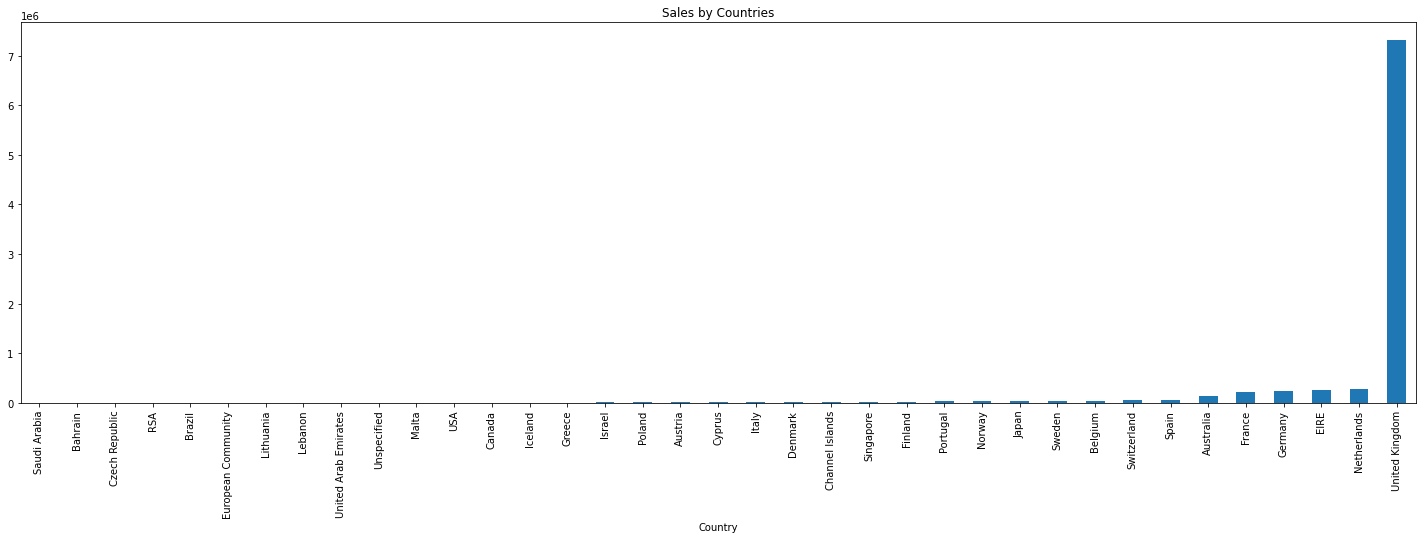

In [13]:
fig = plt.figure(figsize=(25, 7))
f1=fig.add_subplot()
c=data.groupby(["Country"]).Amount.sum().sort_values(ascending=True).plot(kind='bar',title='Sales by Countries')

In [0]:
inv = data[["Description", "InvoiceNo"]].groupby(["Description"]).InvoiceNo.unique().agg(np.size).sort_values(ascending = False)

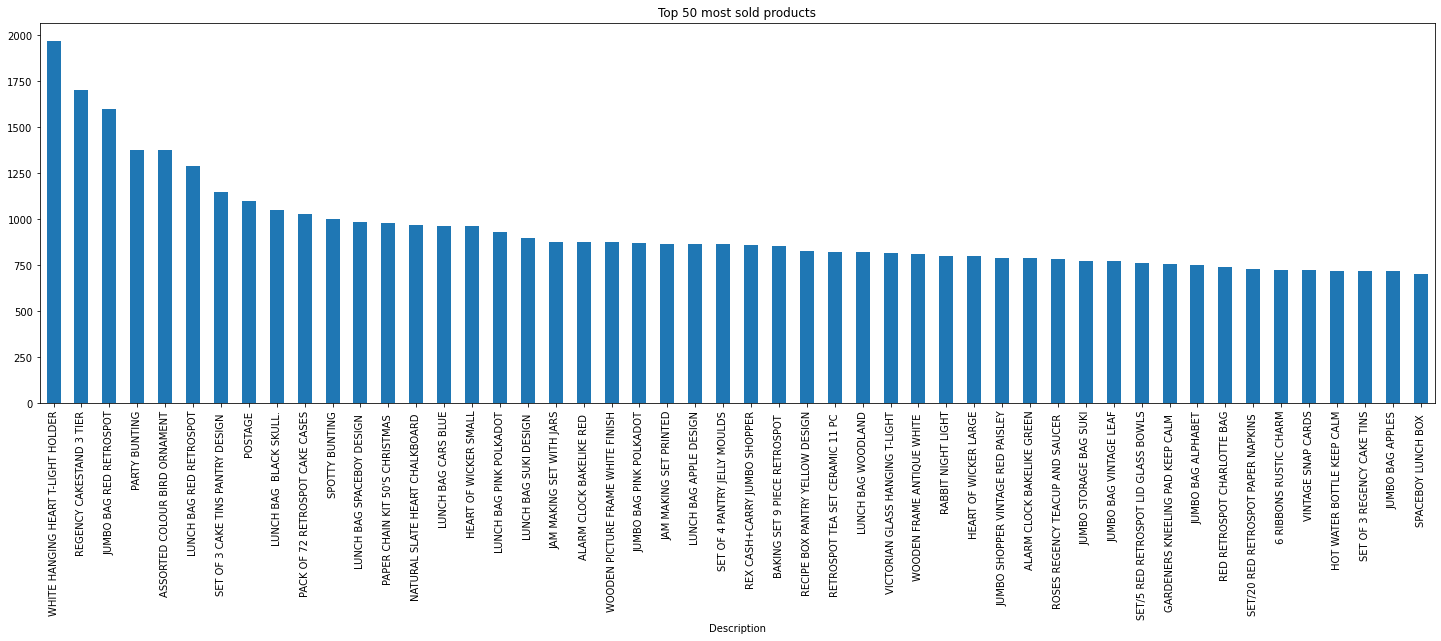

In [15]:
fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
g = inv[Top50Ev].plot(kind='bar', title='Top 50 most sold products')

In [16]:
# RFM Model
# recency
refrence_date = data.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
data['Recency'] = (refrence_date - data.InvoiceDate).astype('timedelta64[D]')
customer_history =  data[['CustomerID', 'Recency']].groupby("CustomerID").min().reset_index()
customer_history.describe()

Reference Date: 2011-12-10 12:50:00


,CustomerID,Recency
count,4338.000000,4338.000000
mean,15300.408022,92.536422
std,1721.808492,100.014169
min,12346.000000,1.000000
25%,13813.250000,18.000000
50%,15299.500000,51.000000
75%,16778.750000,142.000000
max,18287.000000,374.000000


In [0]:
#frequency
customer_freq = (data[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history= customer_history.merge(customer_freq)

In [18]:
customer_history.describe()

,CustomerID,Recency,frequency
count,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015
std,1721.808492,100.014169,7.697998
min,12346.000000,1.000000,1.000000
25%,13813.250000,18.000000,1.000000
50%,15299.500000,51.000000,2.000000
75%,16778.750000,142.000000,5.000000
max,18287.000000,374.000000,209.000000


In [0]:

#Monetary Values
customer_monetary_val = data[['CustomerID', 'Amount']].groupby("CustomerID").sum().reset_index()
customer_history = customer_history.merge(customer_monetary_val)

In [20]:
customer_history.describe()

,CustomerID,Recency,frequency,Amount
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2054.266460
std,1721.808492,100.014169,7.697998,8989.230441
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,307.415000
50%,15299.500000,51.000000,2.000000,674.485000
75%,16778.750000,142.000000,5.000000,1661.740000
max,18287.000000,374.000000,209.000000,280206.020000


In [21]:
customer_history

,CustomerID,Recency,frequency,Amount
0,12346.0,326.0,1,77183.60
1,12347.0,2.0,7,4310.00
2,12348.0,75.0,4,1797.24
3,12349.0,19.0,1,1757.55
4,12350.0,310.0,1,334.40
...,...,...,...,...
4333,18280.0,278.0,1,180.60
4334,18281.0,181.0,1,80.82
4335,18282.0,8.0,2,178.05
4336,18283.0,4.0,16,2094.88


In [0]:
customer_history['recency_log'] = customer_history['Recency'].apply(math.log)
customer_history['frequency_log'] = customer_history['frequency'].apply(math.log)
customer_history['amount_log'] = customer_history['Amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']


In [23]:
customer_history

,CustomerID,Recency,frequency,Amount,recency_log,frequency_log,amount_log
0,12346.0,326.0,1,77183.60,5.786897,0.000000,11.253942
1,12347.0,2.0,7,4310.00,0.693147,1.945910,8.368693
2,12348.0,75.0,4,1797.24,4.317488,1.386294,7.494007
3,12349.0,19.0,1,1757.55,2.944439,0.000000,7.471676
4,12350.0,310.0,1,334.40,5.736572,0.000000,5.812338
...,...,...,...,...,...,...,...
4333,18280.0,278.0,1,180.60,5.627621,0.000000,5.196285
4334,18281.0,181.0,1,80.82,5.198497,0.000000,4.392224
4335,18282.0,8.0,2,178.05,2.079442,0.693147,5.182064
4336,18283.0,4.0,16,2094.88,1.386294,2.772589,7.647252


In [0]:
customer_history.to_csv('cus_id.csv')

In [0]:
from sklearn.preprocessing import StandardScaler
X_subset = customer_history[feature_vector]
scaler = StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
data_frame= pd.DataFrame(X_scaled, columns=X_subset.columns)

In [26]:
X_scaled

array([[ 3.69871931,  1.40989446, -1.04861045],
       [ 1.410201  , -2.14649825,  1.11183567],
       [ 0.71641884,  0.38397128,  0.49052242],
       ...,
       [-1.11736527, -1.17860486, -0.27904402],
       [ 0.83796882, -1.66255156,  2.02965529],
       [ 0.73389579, -0.00442205,  0.17112349]])

In [0]:
import pickle
pickle.dump(scaler,open('scaling','wb'))

In [28]:
from sklearn.externals import joblib
joblib.dump(scaler, 'my_scaler.pkl')     # save to disk

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['my_scaler.pkl']

In [0]:
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [0]:
save_obj(scaler,'scale')

In [31]:
data_frame.describe()

,amount_log,recency_log,frequency_log
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,-1.202102e-16,-1.027980e-16,-2.355833e-16
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-4.179280e+00,-2.630445e+00,-1.048610e+00
25%,-6.841832e-01,-6.124235e-01,-1.048610e+00
50%,-6.094235e-02,1.147066e-01,-2.790440e-01
75%,6.542440e-01,8.296516e-01,7.382675e-01
max,4.721395e+00,1.505796e+00,4.882714e+00


In [32]:
data_frame

,amount_log,recency_log,frequency_log
0,3.698719,1.409894,-1.048610
1,1.410201,-2.146498,1.111836
2,0.716419,0.383971,0.490522
3,0.698706,-0.574674,-1.048610
4,-0.617446,1.374758,-1.048610
...,...,...,...
4333,-1.106086,1.298690,-1.048610
4334,-1.743850,0.999081,-1.048610
4335,-1.117365,-1.178605,-0.279044
4336,0.837969,-1.662552,2.029655


In [0]:
data_frame.to_csv('data_frame2.csv')

In [0]:
cus_id=pd.read_csv('/content/cus_id.csv')

In [0]:
ids=pd.DataFrame(cus_id['CustomerID'])

In [36]:
ids

,CustomerID
0,12346.0
1,12347.0
2,12348.0
3,12349.0
4,12350.0
...,...
4333,18280.0
4334,18281.0
4335,18282.0
4336,18283.0


In [0]:
df=pd.read_csv('/content/data_frame2.csv')

In [41]:
df.shape

(4338, 4)

In [0]:
final_df=ids.join(df)

In [43]:
final_df

,CustomerID,Unnamed: 0,amount_log,recency_log,frequency_log
0,12346.0,0,3.698719,1.409894,-1.048610
1,12347.0,1,1.410201,-2.146498,1.111836
2,12348.0,2,0.716419,0.383971,0.490522
3,12349.0,3,0.698706,-0.574674,-1.048610
4,12350.0,4,-0.617446,1.374758,-1.048610
...,...,...,...,...,...
4333,18280.0,4333,-1.106086,1.298690,-1.048610
4334,18281.0,4334,-1.743850,0.999081,-1.048610
4335,18282.0,4335,-1.117365,-1.178605,-0.279044
4336,18283.0,4336,0.837969,-1.662552,2.029655


In [0]:
#final_df=final_df.drop(['Unnamed: 0'],axis=1)

In [0]:
final_df.to_csv('final_df.csv')

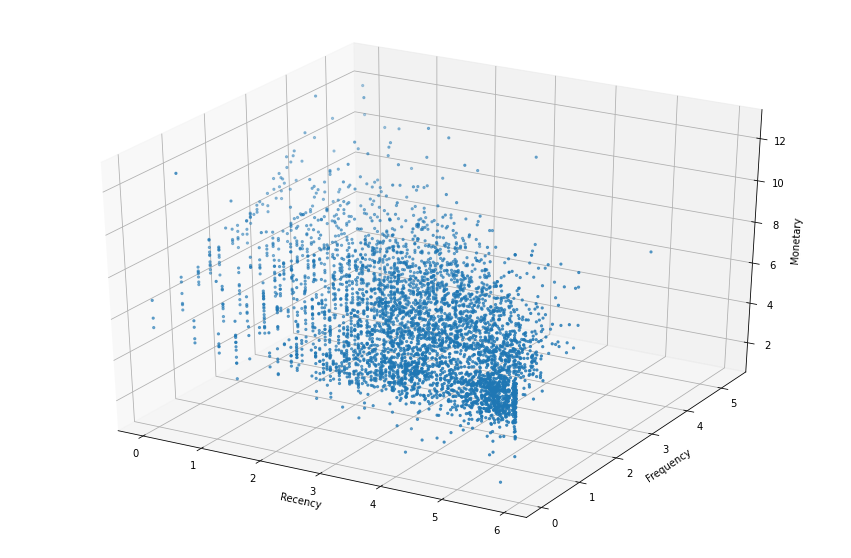

In [46]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history.recency_log
ys = customer_history.frequency_log
zs = customer_history.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

In [0]:

distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data_frame)
    distortions.append(kmeanModel.inertia_)

Text(0.5, 1.0, 'The Elbow Method showing the optimal k')

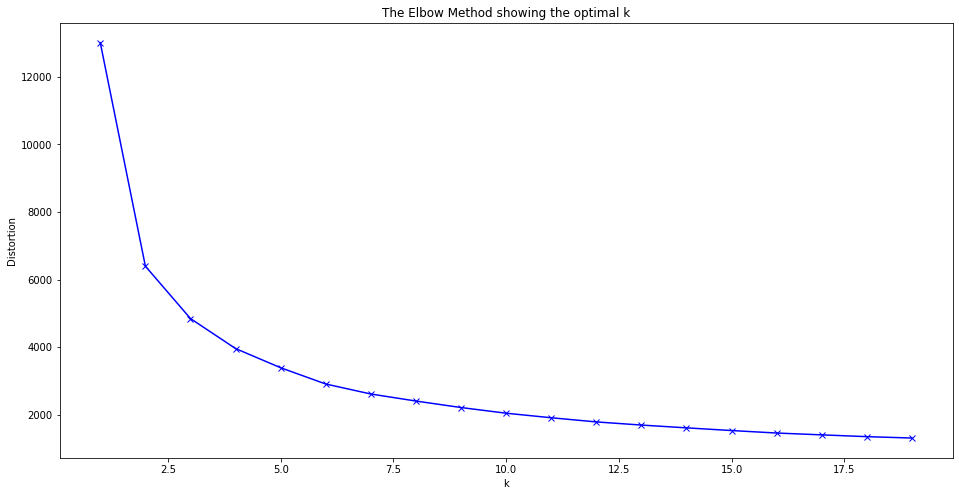

In [48]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

In [49]:
k_means=KMeans(n_clusters=7)
kmeans=k_means.fit_predict(data_frame)
print(kmeans)

[2 0 2 ... 5 0 2]


In [50]:
k_means.cluster_centers_

array([[ 0.84527547, -1.58677321,  1.0062947 ],
       [ 0.08874353,  0.63569057, -0.13465786],
       [ 0.946724  , -0.09428847,  0.94186773],
       [-1.0045743 ,  1.152208  , -0.95910748],
       [ 2.08904908, -1.51710365,  2.31269537],
       [-0.07843542, -0.80489488,  0.03356509],
       [-0.88077278, -0.11594888, -0.91115155]])